In [1]:
import os
import pandas as pd
import numpy as np

# SENNA

**SENNA** *(Semantic/Syntactic Extraction using a Neural Network Architecture)* – архитектура нейронной сети, позволяющая достигнуть state-of-the-art результатов в нескольких задачах обработки текстов. 

* POS (part-of-speech tagging)
* CHK (chunking)
* NER (named entity recognition)
* SRL (semantic role labeling)

Предложен в статье [Natural Language Processing (almost) from Scratch](https://arxiv.org/pdf/1103.0398.pdf) (R. Collobert, J.  Weston, L. Bottou, M. Karlen, K. Kavukcuoglu, P. Kuksa, 2011).

Основное преимущество подхода ("almost from scratch") — не нужно генерировать фичи под каждую из задач, NN сама выучивает "внутренние представления" (~ эмбеддинги). При желании можно добавить фичи самостоятельно.

## Архитектура

SENNA — многослойная сеть прямого распространения. Как и любую такую сеть, ее можно представить в виде комбинации функций, каждая из которых соответствует какому-либо слою.

$$f_\theta(\cdot) = f_\theta^L(f_\theta^{L-1}(\dots f_\theta^1(\cdot)\dots)) $$

### Window-approach 

<img src="img/senna1.png" align="left">


1. Первый слой — Lookup Table, $LT_W(\cdot)$

  * $LT_W(w) = \langle W_w^1\rangle$
  * Слова кодируются индексами из словаря $D$ с помощью one-hot encoding
  * $d_{wrd}$ — размер вектора, соответствующего слову (гиперпараметр)
  * $d_{win}$ — размер окна (гиперпараметр). В данном подходе всегда используется нечетное число.
  * По краям предложения добавляются символы padding с обеих сторон в количестве $(d_{win} - 1)/2$
  * Для незнакомых слов также вводится специальный символ
  * $W$ — матрица параметров, которые должна выучить сеть, $W \in \mathbb{R}^{d_{wrd}\times|D|}$
  * $\langle W_w^1\rangle \in \mathbb{R}^{d_{wrd}}$ — W-тый столбец матрицы W
  * $T$ — количество слов в последовательности
  * Выход слоя $LT_W(\cdot)$ — матрица:  
  $LT_W([w_1^T]) = \left( \langle W^1_{[w]_1}\rangle \langle W^1_{[w]_2}\rangle \dots \langle W^1_{[w]_T}\rangle \right)$
  * Т.е. эмбеддинги слов из окна конкатенируются, и это подается на вход следующему слою. Размер  матрицы, которую выдет lookup table — $d_{wrd} \times d_{win}$
  * Если мы добавляем какие-то фичи — результатом будет конкатенация выходов lookup table для каждой
  
  
  2. Второй слой — линейная функция
  
    * $f_\theta^l = W^lf^{l-1}_\theta + b^l$
    * Параметры: $W^l \in \mathbb{R}^{n^l_{hu} \times n^{l-1}_{hu}}$ и $b \in \mathbb{R}^{n^l_{hu}}$
    * $n^l_{hu}$ — гиперпараметр, количество нейронов (hidden units) на $l$-ом слое
    
3. Скрытый слой. Нелинейная функция активации — гиперболический тангенс
   *  $\left[ f^l_\theta \right]_i = HardTanh \left( \left[ f^{l-1}_\theta \right]_i\right)$
   
  
4. Выходной слой — SoftMax
 
   *  Размер выходного слоя $L =$ количеству возможных меток (например, POS-тегов)
   *  Каждый output — это оценка (score) соответствующего тега  
 
 
## Sentence Approach

<img src="img/senna.png" align="left">

Лучше работает для задачи маркирования семантических ролей, т.к. предикат может быть далеко от своего аргумента и не попасть в окно.

1. Lookup Table
2. Сверточный слой — извлекает локальный контекст для каждого слова
3. Max Over Time по всему предложению — размерность выхода сверточного слоя зависит от размера предложения
4. Дальше как раньше (линейная функция → нелинейная → линейная)


## Word-level Log-likelihood

$$ p(i|x, \theta) = \frac{exp^{f_\theta(x)_i}}{\sum_jexp^{f_\theta(x)_j}}$$ 
$$ p(y|x, \theta) = f_\theta(x)_y - logadd_jf_\theta(x)_j$$

* $x$ — инпут
* $\theta$ — параметры модели
* $i$ — номер тега
* $f_\theta(x)_i$ — оценка для i-того тега, которую выдала модель
* Недостаток: не принимаем во внимание теги соседних слов. Для этого вводим дополнительный параметр transition score от i-того до j-того тега и считаем sentence-level log-likelihood (подробнее см. в статье).


## Задача POS-tagging
ставится как задача многоклассовой классификации: 
* $T$ — количество различных тегов частей речи (каждое слово $w$ относится к одному из $T$ классов)
* для каждого слова из train формируется вектор признаков 
* NN обучается по всем векторам признаков каждого слова из train 

### Подход к решению 
Window approach network, раздел 3.3.1 в статье.
1. Каждое слово представляется эмбеддингом размерности $d$;
2. Для каждого слова формируется окно длины $k$ из $(k-1)/2$ соседних слов слева от данного слова  и $(k-1)/2$ соседних слов справа от данного слова, $k$ – нечетное. (Если для слова невозможно найти соседние слова, используется padding.)
3. Для каждого слова формируется вектор признаков, состоящий из конкатенированных эмбеддингов слов из левого окна, данного слова и слов из правого окна. Итоговая размерность вектора признаков – $d \times k$. Этот вектор подается на вход нейронной сети;
4. Обучается нейронная сеть, имеющая один скрытый слой с $n_h$ нейроннами и нелинейной функцией активации $\theta$;
5. На выходном слое нейронной сети решается задача классификации на |T| классов. 


### Данные

* [Предобученные эмбеддинги Facebook для русского](https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.ru.vec) (а [вот тут](https://fasttext.cc/docs/en/pretrained-vectors.html) список всех, что есть)
* [Данные](https://www.dropbox.com/s/n5pgf9nu50jvwra/unamb_sent_14_6.conllu) (морфологически и синтаксически размеченные предложения в формате conllu).

**NB!** Можно просто перейти по ссылке и сохранить данные, а можно скачать так, как в примере ниже. Если у вас Windows, то нужно сначала скачать `wget` [вот отсюда](https://eternallybored.org/misc/wget/) и добавить путь к папке с этим фалом в `PATH`. 

In [5]:
!wget https://www.dropbox.com/s/n5pgf9nu50jvwra/unamb_sent_14_6.conllu
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.ru.vec

### 1. Составляем обучающую выборку 

- считываем выборку 
- делим на train, test по предложениям
- каждое предложение внутри каждого из множества разделям на слова (оставляем структуру предложения в виде list, потому что нам потребуется контекст: слова слева и справа)

In [6]:
path = 'data/unamb_sent_14_6.conllu'
project_path = os.getcwd()

`ConllCorpusReader` — инструмент для работы с корпусами в разметке conll.

In [7]:
from nltk.corpus.reader import ConllCorpusReader

pos_corpus = ConllCorpusReader(project_path, fileids = path, 
                               columntypes = ['ignore', 'words', 'ignore', 'pos', 'chunk'])
sents = list(pos_corpus.iob_sents())

In [8]:
pos_tags = set([pos for text in sents for word, pos, chunk in text])

In [10]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(sents, test_size=0.25)
sent_train = [[word[0].lower() for word in sent]for sent in train]
label_train = [[word[1] for word in sent] for sent in train]
sent_test = [[word[0].lower() for word in sent]for sent in test]
label_test = [[word[1] for word in sent] for sent in test]

### 2. Считываем эмбеддинги

Далее будем подавать эмбеддинги на вход Embedding layer в поле weights (матрица). Матрица train при этом должна быть integer-encoded (слову соответствует индекс), т.е. строка матрицы — контекст слова, для которого есть POS-метка. Каждому слову из окна соответствует один столбец.

- Будем хранить не все эмбеддинги, а только для слов, которые встречаются в train и test: надо сохранить сами эмбеддинги в матрицу (word_embeddings), и запомнить соответствие «слово — индекс в матрице» (word_2_idx)
- Будьте внимательны с кодировкой .de(en)code('utf-8')
- Не забудем о PADDING, UNKNOWN (для некоторых слов не существует контекста, в этом случае эмбеддинг будет из нулей; для некоторых слов не найдется предобученного эмбеддинга, создадим для таких слов эмбеддинг np.random.uniform)

In [11]:
# составляем словарь
words = set()

for sent_set in [sent_train, sent_test]:
    for sentence in sent_set:
        for token in sentence:
            words.add(token.lower())

In [12]:
# tqdm измеряет время выполнения цикла
from tqdm import tqdm
import numpy as np

word_2_idx = {}
word_embeddings = []
with open('data/wiki.ru.vec', 'rb') as f :
    for line in tqdm(f):
        values = line.split()
        if len(values) != 301:
            continue
            
        if len(word_2_idx) == 0:
            word_2_idx["padding"] = len(word_2_idx)
            vector = np.zeros(len(values)-1) 
            word_embeddings.append(vector)

            word_2_idx["unknown"] = len(word_2_idx)
            vector = np.random.uniform(-0.25, 0.25, len(values)-1)
            word_embeddings.append(vector)
            values = line.split()
            
        if  values[0].lower().decode('utf-8') in words:
            vector = np.asarray(values[1:], dtype='float32')
            word_embeddings.append(vector)
            word_2_idx[values[0].lower()] = len(word_2_idx)
            
            
word_embeddings = np.array(word_embeddings)

1888424it [01:41, 18653.39it/s]


In [13]:
word_embeddings.shape, len(word_2_idx), len(words)

((70789, 300), 70789, 79791)

### 3. Составляем train

- Сформируем окно для каждого слова размера $k$
- Закодируем каждое слово из контекста индексом, соответсвующим этому слову в матрице эмбеддингов
- Не забываем про padding, unknown

### 4. Составляем test
- Кодируем каждый label индексом

In [14]:
WINDOWSIZE = 5
UNKNOWN_IDX = word_2_idx['unknown']
PADDING_IDX = word_2_idx['padding']

In [15]:
def get_context(tgt_word_idx, sentence, windowsize):
    context = []  
    for word_position in range(tgt_word_idx - windowsize, tgt_word_idx + windowsize+1):
        if word_position < 0 or word_position >= len(sentence):
            context.append("padding")
            continue
        word = sentence[word_position]
        context.append(word)   
    return context


# сюда будем записывать не сами слова, а индекс эмбеддинга
X_train = []

for sentence in sent_train:
    for tgt_word_idx in range(len(sentence)):
        tgt_word_context = get_context(tgt_word_idx, sentence, WINDOWSIZE//2)
        X_train.append([word_2_idx.get(word.encode('utf-8'), UNKNOWN_IDX) for word in tgt_word_context])

        
label_2_idx = {}
for label in pos_tags:
    label_2_idx[label] = len(label_2_idx)
y_train = []
for el in label_train:
    y_train.extend([label_2_idx.get(label) for label in el])
    
X_train = np.array(X_train)
y_train = np.array(y_train)

### 5. Обучаем NN

Задаем модель с помощью фреймворка `Keras`, который может работать на backend'e `tensorflow` или `theano`. У него отличная [документация](https://keras.io/).

Вот что используется в нашей модели:
* [Базовые слои](https://keras.io/layers/core/)
    * Input — инициализируем тензор
    * Dense — полносвязный слой
    * Flatten — вытягивает матрицу в длинный вектор
* В качестве входа самой сетке мы подаем эмбеддинги, это [Еmbedding layer](https://keras.io/layers/embeddings/)
* [Функция потерь](https://keras.io/losses/) — категориальная кроссэнтропия
* [Оптимизатор](https://keras.io/optimizers/) — Nesterov Adam Optimizer. Кстати, на хабре есть [очень хорошая статья](https://habr.com/ru/post/318970/) про методы оптимизации нейронных сетей).
* [Функции активации](https://keras.io/activations/) для полносвязных слоев — softmax и гиперболический тангенс. 

In [23]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Embedding

n_in = X_train.shape[1] # размер окна
n_out = len(label_2_idx) # количество классов

# trainable=False — используем готовые эмбеддинги, не дообучаем
# каждый вход — окно из n слов
words_input = Input(shape=(n_in,), dtype='int32', name='words_input') 

words = Embedding(input_dim=word_embeddings.shape[0], output_dim=word_embeddings.shape[1], 
                  weights=[word_embeddings], trainable=False)(words_input)

words = Flatten()(words)  # вытягивает матрицу в длинный вектор

output = Dense(64, activation='tanh')(words)
output = Dense(n_out, activation='softmax')(output)

model = Model(inputs=[words_input], outputs=[output])
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam')

# описание модели
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
words_input (InputLayer)     (None, 5)                 0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 5, 300)            21236700  
_________________________________________________________________
flatten_3 (Flatten)          (None, 1500)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                96064     
_________________________________________________________________
dense_6 (Dense)              (None, 14)                910       
Total params: 21,333,674
Trainable params: 96,974
Non-trainable params: 21,236,700
_________________________________________________________________


Собственно обучение модели.

In [24]:
model.fit(X_train, y_train, epochs= 2, batch_size = 32, validation_split = 0.1)

Train on 309798 samples, validate on 34423 samples
Epoch 1/2


125952/309798 [===========>..................] - ETA: 44:05 - loss: 2.61 - ETA: 4:25 - loss: 2.2180 - ETA: 2:47 - loss: 2.003 - ETA: 2:06 - loss: 1.815 - ETA: 1:53 - loss: 1.728 - ETA: 1:38 - loss: 1.606 - ETA: 1:24 - loss: 1.478 - ETA: 1:15 - loss: 1.371 - ETA: 1:10 - loss: 1.287 - ETA: 1:06 - loss: 1.221 - ETA: 1:07 - loss: 1.186 - ETA: 1:06 - loss: 1.150 - ETA: 1:05 - loss: 1.123 - ETA: 1:03 - loss: 1.078 - ETA: 1:02 - loss: 1.043 - ETA: 1:00 - loss: 1.012 - ETA: 59s - loss: 0.976 - ETA: 57s - loss: 0.94 - ETA: 55s - loss: 0.91 - ETA: 55s - loss: 0.88 - ETA: 54s - loss: 0.85 - ETA: 53s - loss: 0.84 - ETA: 52s - loss: 0.82 - ETA: 51s - loss: 0.80 - ETA: 50s - loss: 0.78 - ETA: 49s - loss: 0.76 - ETA: 48s - loss: 0.74 - ETA: 48s - loss: 0.73 - ETA: 47s - loss: 0.71 - ETA: 47s - loss: 0.70 - ETA: 46s - loss: 0.68 - ETA: 46s - loss: 0.67 - ETA: 45s - loss: 0.66 - ETA: 45s - loss: 0.65 - ETA: 44s - loss: 0.64 - ETA: 44s - loss: 0.63 - ETA: 44s - loss: 0.62 - ETA: 44s - loss: 0.61 - ETA: 

263552/309798 [========================>.....] - ETA: 26s - loss: 0.29 - ETA: 25s - loss: 0.29 - ETA: 25s - loss: 0.29 - ETA: 25s - loss: 0.29 - ETA: 25s - loss: 0.29 - ETA: 25s - loss: 0.29 - ETA: 25s - loss: 0.29 - ETA: 25s - loss: 0.29 - ETA: 25s - loss: 0.29 - ETA: 25s - loss: 0.29 - ETA: 25s - loss: 0.29 - ETA: 25s - loss: 0.29 - ETA: 25s - loss: 0.29 - ETA: 25s - loss: 0.29 - ETA: 25s - loss: 0.29 - ETA: 25s - loss: 0.28 - ETA: 25s - loss: 0.28 - ETA: 25s - loss: 0.28 - ETA: 25s - loss: 0.28 - ETA: 25s - loss: 0.28 - ETA: 25s - loss: 0.28 - ETA: 25s - loss: 0.28 - ETA: 24s - loss: 0.28 - ETA: 24s - loss: 0.28 - ETA: 24s - loss: 0.28 - ETA: 24s - loss: 0.28 - ETA: 24s - loss: 0.28 - ETA: 24s - loss: 0.28 - ETA: 24s - loss: 0.28 - ETA: 24s - loss: 0.28 - ETA: 24s - loss: 0.28 - ETA: 24s - loss: 0.28 - ETA: 24s - loss: 0.28 - ETA: 24s - loss: 0.28 - ETA: 24s - loss: 0.28 - ETA: 23s - loss: 0.28 - ETA: 23s - loss: 0.28 - ETA: 23s - loss: 0.28 - ETA: 23s - loss: 0.28 - ETA: 23s - loss

309798/309798 [==============================] - ETA: 6s - loss: 0.245 - ETA: 6s - loss: 0.245 - ETA: 6s - loss: 0.245 - ETA: 6s - loss: 0.244 - ETA: 5s - loss: 0.244 - ETA: 5s - loss: 0.244 - ETA: 5s - loss: 0.244 - ETA: 5s - loss: 0.244 - ETA: 5s - loss: 0.244 - ETA: 5s - loss: 0.244 - ETA: 5s - loss: 0.244 - ETA: 5s - loss: 0.244 - ETA: 5s - loss: 0.244 - ETA: 5s - loss: 0.244 - ETA: 5s - loss: 0.244 - ETA: 5s - loss: 0.243 - ETA: 5s - loss: 0.243 - ETA: 5s - loss: 0.243 - ETA: 4s - loss: 0.243 - ETA: 4s - loss: 0.243 - ETA: 4s - loss: 0.243 - ETA: 4s - loss: 0.243 - ETA: 4s - loss: 0.243 - ETA: 4s - loss: 0.243 - ETA: 4s - loss: 0.243 - ETA: 4s - loss: 0.243 - ETA: 4s - loss: 0.242 - ETA: 4s - loss: 0.242 - ETA: 4s - loss: 0.242 - ETA: 4s - loss: 0.242 - ETA: 4s - loss: 0.242 - ETA: 4s - loss: 0.242 - ETA: 4s - loss: 0.242 - ETA: 3s - loss: 0.242 - ETA: 3s - loss: 0.242 - ETA: 3s - loss: 0.242 - ETA: 3s - loss: 0.242 - ETA: 3s - loss: 0.242 - ETA: 3s - loss: 0.242 - ETA: 3s - loss:

127104/309798 [===========>..................] - ETA: 4:49 - loss: 0.069 - ETA: 48s - loss: 0.163 - ETA: 43s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 38s - loss: 0.13 - ETA: 37s - loss: 0.14 - ETA: 37s - loss: 0.14 - ETA: 36s - loss: 0.15 - ETA: 35s - loss: 0.14 - ETA: 34s - loss: 0.14 - ETA: 34s - loss: 0.14 - ETA: 35s - loss: 0.14 - ETA: 35s - loss: 0.14 - ETA: 35s - loss: 0.14 - ETA: 34s - loss: 0.14 - ETA: 34s - loss: 0.14 - ETA: 34s - loss: 0.14 - ETA: 33s - loss: 0.14 - ETA: 33s - loss: 0.14 - ETA: 33s - loss: 0.15 - ETA: 32s - loss: 0.14 - ETA: 32s - loss: 0.14 - ETA: 32s - loss: 0.14 - ETA: 32s - loss: 0.14 - ETA: 31s - loss: 0.15 - ETA: 31s - loss: 0.15 - ETA: 31s - loss: 0.14 - ETA: 31s - loss: 0.15 - ETA: 31s - loss: 0.14 - ETA: 31s - loss: 0.14 - ETA: 31s - loss: 0.15 - ETA: 31s - loss: 0.14 - ETA: 32s - loss: 0.14 - ETA: 32s - loss: 0.14 - ETA: 32s - loss: 0.14 - ETA: 32s - loss: 0.14 - ETA: 32s - loss: 0.14 - ETA: 32s - loss: 0.14 - ETA: 31s - loss: 0.14 - ETA: 31s - l

272608/309798 [=========================>....] - ETA: 25s - loss: 0.15 - ETA: 25s - loss: 0.15 - ETA: 25s - loss: 0.15 - ETA: 25s - loss: 0.15 - ETA: 25s - loss: 0.15 - ETA: 25s - loss: 0.15 - ETA: 25s - loss: 0.15 - ETA: 25s - loss: 0.15 - ETA: 25s - loss: 0.15 - ETA: 25s - loss: 0.15 - ETA: 25s - loss: 0.15 - ETA: 25s - loss: 0.15 - ETA: 25s - loss: 0.15 - ETA: 25s - loss: 0.15 - ETA: 25s - loss: 0.15 - ETA: 25s - loss: 0.15 - ETA: 25s - loss: 0.15 - ETA: 25s - loss: 0.15 - ETA: 25s - loss: 0.15 - ETA: 25s - loss: 0.15 - ETA: 24s - loss: 0.15 - ETA: 24s - loss: 0.15 - ETA: 24s - loss: 0.15 - ETA: 24s - loss: 0.15 - ETA: 24s - loss: 0.15 - ETA: 24s - loss: 0.15 - ETA: 24s - loss: 0.15 - ETA: 24s - loss: 0.15 - ETA: 24s - loss: 0.15 - ETA: 24s - loss: 0.15 - ETA: 24s - loss: 0.15 - ETA: 24s - loss: 0.15 - ETA: 24s - loss: 0.15 - ETA: 24s - loss: 0.15 - ETA: 24s - loss: 0.15 - ETA: 24s - loss: 0.15 - ETA: 24s - loss: 0.15 - ETA: 24s - loss: 0.15 - ETA: 24s - loss: 0.15 - ETA: 24s - loss

309798/309798 [==============================] - ETA: 4s - loss: 0.157 - ETA: 4s - loss: 0.157 - ETA: 4s - loss: 0.157 - ETA: 4s - loss: 0.157 - ETA: 4s - loss: 0.157 - ETA: 4s - loss: 0.157 - ETA: 4s - loss: 0.157 - ETA: 4s - loss: 0.157 - ETA: 4s - loss: 0.157 - ETA: 4s - loss: 0.157 - ETA: 4s - loss: 0.157 - ETA: 4s - loss: 0.157 - ETA: 4s - loss: 0.157 - ETA: 4s - loss: 0.157 - ETA: 4s - loss: 0.157 - ETA: 4s - loss: 0.157 - ETA: 4s - loss: 0.157 - ETA: 4s - loss: 0.157 - ETA: 4s - loss: 0.157 - ETA: 4s - loss: 0.157 - ETA: 4s - loss: 0.157 - ETA: 4s - loss: 0.157 - ETA: 4s - loss: 0.157 - ETA: 3s - loss: 0.157 - ETA: 3s - loss: 0.157 - ETA: 3s - loss: 0.157 - ETA: 3s - loss: 0.157 - ETA: 3s - loss: 0.157 - ETA: 3s - loss: 0.157 - ETA: 3s - loss: 0.157 - ETA: 3s - loss: 0.157 - ETA: 3s - loss: 0.157 - ETA: 3s - loss: 0.157 - ETA: 3s - loss: 0.157 - ETA: 3s - loss: 0.157 - ETA: 3s - loss: 0.157 - ETA: 3s - loss: 0.157 - ETA: 3s - loss: 0.157 - ETA: 3s - loss: 0.157 - ETA: 3s - loss:

### 6. Делаем предсказание для test
- Составляем test
- Применяем модель (предсказываем POS-тег для каждого слова в тестовой выборке)
- Смотрим на качество (accuracy по всем категориям и precision, recall, f1-score для каждой категории отдельно) 

In [25]:
X_test = []

for sentence in sent_test:
    for tgt_word_idx in range(len(sentence)):
        tgt_word_context = get_context(tgt_word_idx, sentence, WINDOWSIZE//2)
        X_test.append([word_2_idx.get(word.encode('utf-8'), UNKNOWN_IDX) for word in tgt_word_context])
        
y_test = []
for el in label_test:
    y_test.extend([label_2_idx.get(label) for label in el])
    
X_test = np.array(X_test)
y_test = np.array(y_test)

In [26]:
idx_2_label = {v: k for k, v in label_2_idx.items()}
pred = model.predict(X_test)
t = np.array([idx_2_label[i] for i in y_test])
p = np.array([idx_2_label[i] for i in np.argmax(pred, axis=1)])

In [29]:
from sklearn.metrics import *

print('Accuracy: %s' % np.mean(t==p)) 
print(classification_report(t, p))

Accuracy: 0.9449286356980293
              precision    recall  f1-score   support

         ADJ       0.95      0.92      0.93     11879
         ADP       0.99      0.99      0.99     10567
         ADV       0.88      0.89      0.88      3256
        CONJ       0.97      0.96      0.97      5494
         DET       0.97      0.94      0.96      3068
        INTJ       0.56      0.49      0.52        97
        NOUN       0.96      0.97      0.97     30239
         NUM       0.86      0.78      0.82      2448
        PART       0.89      0.94      0.92      2182
        PRON       0.96      0.96      0.96      2299
       PROPN       0.82      0.90      0.85      3546
       PUNCT       0.97      0.98      0.98     22656
        VERB       0.98      0.96      0.97     10241
           X       0.71      0.70      0.70      5390

   micro avg       0.94      0.94      0.94    113362
   macro avg       0.89      0.89      0.89    113362
weighted avg       0.95      0.94      0.94    1133

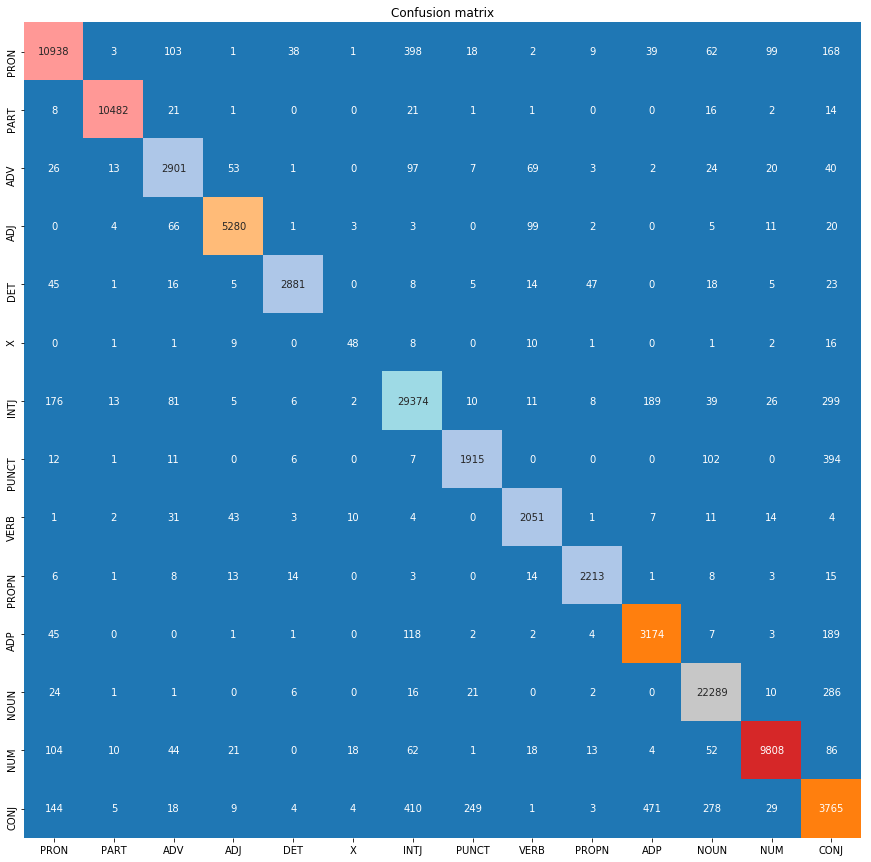

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

m = confusion_matrix(t, p)

labels = label_2_idx.keys()
plt.figure(figsize = (15,15))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap='tab20')
plt.title("Confusion matrix")
plt.show()